## `estimating_natural_variability_hadGEM3-GC31-MM_historical.ipynb`: create figures of ensemble means and area-weighted yearly mean of sea-ice thickness (historical model hadGEM3-gc31-MM)

In [3]:
import context
import warnings
import intake
import xarray as xr 
import matplotlib.pyplot as plt 
import pandas as pd
import cftime
import gcsfs
import cartopy.crs as ccrs
from pathlib import Path
import pandas as pd
from a448_lib import data_read
import fsspec
import cmocean as cm
import cartopy.feature as cfeature
import numpy as np

found this_dir=PosixPath('/home/jovyan/work/data_share')
found lib_dir=PosixPath('/home/jovyan/work/data_share/a448_lib')
******************************
context imported. Front of path:
/home/jovyan/work/data_share
back of path: /home/jovyan/.ipython
******************************



### Grab json file with all of the data from cmip6

* Download the catalog in csv and json format

In [4]:
csv_filename = "pangeo-cmip6.csv"
root = "https://storage.googleapis.com/cmip6"
if Path(csv_filename).is_file():
    print(f"found {csv_filename}")
else:
    print(f"downloading {csv_filename}")
    data_read.download(csv_filename,root=root)
    
json_filename="https://storage.googleapis.com/cmip6/pangeo-cmip6.json"

found pangeo-cmip6.csv


* make a dataframe from the csv version

In [5]:
catalog_df=pd.read_csv(csv_filename)
catalog_df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,hurs,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauv,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ta,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


* make an intake collection from the json version

In [6]:
col = intake.open_esm_datastore(json_filename)

In [7]:
col

,unique
activity_id,17
institution_id,36
source_id,86
experiment_id,168
member_id,650
table_id,37
variable_id,709
grid_label,10
zstore,492409
dcpp_init_year,60


## First show all MOHC historical runs

In [8]:
source = "HadGEM3-GC31-MM"
query = dict(
    experiment_id=['historical'],
    institution_id = "MOHC",
    source_id = source,
    table_id=["SImon"],
    variable_id=['sithick'])

col_subset = col.search(require_all_on=["source_id"],**query)

In [9]:
col_subset.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,HadGEM3-GC31-MM,historical,r1i1p1f3,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-MM/his...,NaN,20191207
1,CMIP,MOHC,HadGEM3-GC31-MM,historical,r2i1p1f3,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-MM/his...,NaN,20191218
2,CMIP,MOHC,HadGEM3-GC31-MM,historical,r3i1p1f3,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-MM/his...,NaN,20200601
3,CMIP,MOHC,HadGEM3-GC31-MM,historical,r4i1p1f3,SImon,sithick,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-MM/his...,NaN,20200601


In [10]:
len(col_subset.df)

list_of_members = col_subset.df

## get the first realization for the sithick dataset

In [11]:
member = 'r1i1p1f3'
filename=col_subset.df.query("member_id=='r1i1p1f3'")['zstore'].iloc[0]

In [12]:
dset_mohc_sithick=xr.open_zarr(fsspec.get_mapper(filename), consolidated=True)
dset_mohc_sithick

<xarray.Dataset>
Dimensions:             (bnds: 2, i: 1440, j: 1205, time: 1980, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 ... 1434 1435 1436 1437 1438 1439
  * j                   (j) int32 0 1 2 3 4 5 ... 1199 1200 1201 1202 1203 1204
    latitude            (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
  * time                (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:0...
    time_bnds           (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: bnds, vertices
Data variables:
    sithick             (time, j, i) float32 dask.array<chunksize=(57, 1205, 1440), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(1205, 1440, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(1205, 1440, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/3bc467eb-adca-426a-842b-26e2ec44af95...
    variable_id:            sithick
    variable_name:          sithick
    variant_label:          r1i1p1f3
    netcdf_tracking_ids:    hdl:21.14100/3bc467eb-adca-426a-842b-26e2ec44af95...
    version_id:             v20191207

## Now get the cell area for the ocean grid

In [13]:
query = dict(
    experiment_id=['piControl'],
    institution_id = "MOHC",
    table_id = "Ofx",
    source_id = source,
    member_id = 'r1i1p1f1',
    variable_id=['areacello'])

col_subset = col.search(require_all_on=["source_id"],**query)
col_subset.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,MOHC,HadGEM3-GC31-MM,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-MM/piC...,NaN,20200108


In [14]:
filename=col_subset.df['zstore'].iloc[0]
filename

'gs://cmip6/CMIP6/CMIP/MOHC/HadGEM3-GC31-MM/piControl/r1i1p1f1/Ofx/areacello/gn/v20200108/'

In [15]:
dset_mohc_areacello=xr.open_zarr(fsspec.get_mapper(filename), consolidated=True)
dset_mohc_areacello

<xarray.Dataset>
Dimensions:             (i: 1440, j: 1205, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 ... 1434 1435 1436 1437 1438 1439
  * j                   (j) int32 0 1 2 3 4 5 ... 1199 1200 1201 1202 1203 1204
    latitude            (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Dimensions without coordinates: vertices
Data variables:
    areacello           (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(1205, 1440, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(1205, 1440, 4), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  127080.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/eb687ab1-e42a-4b68-9071-dbdc6082b910
    variable_id:            areacello
    variable_name:          areacello
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/eb687ab1-e42a-4b68-9071-dbdc6082b910
    version_id:             v20200108

## Plot the lat/lon for this curvilinear ocean grid

In [16]:
lons = dset_mohc_sithick.longitude
lats = dset_mohc_sithick.latitude
data = dset_mohc_sithick['sithick']

In [17]:
lons.shape
lats.shape
data.shape

(1980, 1205, 1440)

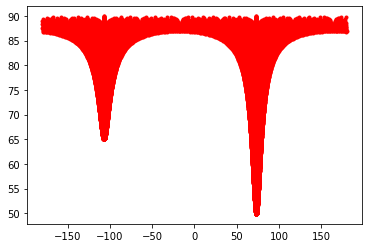

In [18]:
plt.plot(lons[-30:],lats[-30:],'r.');

In [19]:
def deseam(lon, lat, data):
    """
    Function to get rid of the "seam" that shows up on 
    the map when you're using these curvilinear grids.
    """
    i, j = lat.shape
    new_lon = np.zeros((i, j + 1))
    new_lon[:, :-1] = lon
    new_lon[:, -1] = lon[:, 0]

    new_lat = np.zeros((i, j + 1))
    new_lat[:, :-1] = lat
    new_lat[:, -1] = lat[:, 0]

    new_data = np.zeros((i, j + 1))
    new_data[:, :-1] = data
    new_data[:, -1] = data[:, 0]
    new_data = np.ma.array(new_data, mask=np.isnan(new_data))
    return new_lon, new_lat, new_data

In [20]:
lons, lats, newdata = deseam(lons,lats,data[0,:,:])

## Now do a mean climatology: 1970-2000

In [21]:
# Take a seasonal climatology over 1970-2000
climatology = dset_mohc_sithick['sithick'].sel(time=slice('1970', '2000')).groupby('time.season').mean('time')

In [22]:
JJA = climatology.sel(season='JJA').squeeze()
lons, lats, data = deseam(JJA.longitude, JJA.latitude, JJA)

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


## Take the area-weighted mean

In [23]:
dset_mohc_areacello

<xarray.Dataset>
Dimensions:             (i: 1440, j: 1205, vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 ... 1434 1435 1436 1437 1438 1439
  * j                   (j) int32 0 1 2 3 4 5 ... 1199 1200 1201 1202 1203 1204
    latitude            (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    longitude           (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
Dimensions without coordinates: vertices
Data variables:
    areacello           (j, i) float32 dask.array<chunksize=(1205, 1440), meta=np.ndarray>
    vertices_latitude   (j, i, vertices) float32 dask.array<chunksize=(1205, 1440, 4), meta=np.ndarray>
    vertices_longitude  (j, i, vertices) float32 dask.array<chunksize=(1205, 1440, 4), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  127080.0
    cmor_version:           3.4.0
    ...                     ...
    tracking_id:            hdl:21.14100/eb687ab1-e42a-4b68-9071-dbdc6082b910
    variable_id:            areacello
    variable_name:          areacello
    variant_label:          r1i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/eb687ab1-e42a-4b68-9071-dbdc6082b910
    version_id:             v20200108

In [24]:
areacello = dset_mohc_areacello['areacello'].squeeze()

In [25]:
member_ids = list_of_members['member_id']

In [26]:
aw_arctic_ice_series = np.zeros((len(dset_mohc_sithick['time']), len(member_ids)))

icount = 0
for i in member_ids:
    my_memberid = "member_id==" + "\'" + str(i) +"\'"
    filenames = list_of_members.query(my_memberid)['zstore'].iloc[0]
    dset_mohc_sithick=xr.open_zarr(fsspec.get_mapper(filenames), consolidated=True)
    
    sithick = dset_mohc_sithick['sithick'].squeeze()
    
    # Grab north of the equator
    arctic_ice = sithick.where(areacello.latitude > 0)
    arctic_ice = sithick.where(sithick > 0)
    
    # compute area-weighted mean
    #aw_arctic_ice = (arctic_ice * areacello).sum(['j', 'i']) / areacello.sum()
    aw_arctic_ice_series[:, icount] = (arctic_ice * areacello).sum(['j', 'i']) / areacello.sum()
    
    icount = icount + 1
    #lines = aw_arctic_ice.groupby('time.year').mean('time')
    #ax1.grid(True)

aw_arctic_ice_series = pd.DataFrame(aw_arctic_ice_series)  

mean_values = aw_arctic_ice_series.mean(axis=0)
variance_values = np.var(aw_arctic_ice_series, axis=0)

In [27]:
datetimeindex = dset_mohc_sithick.indexes['time'].to_datetimeindex()
aw_arctic_ice_series
aw_arctic_ice_series['datetime'] = datetimeindex
aw_arctic_ice_series = aw_arctic_ice_series.set_index(['datetime'])

<ipython-input-27-100db14817c2>:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  datetimeindex = dset_mohc_sithick.indexes['time'].to_datetimeindex()


In [28]:
yearly_means = aw_arctic_ice_series.groupby([aw_arctic_ice_series.index.year]).mean('datetime')

### Plotting Means and Variability

Text(0.5, 1.0, 'Area Weighted Sea Ice Thickness')

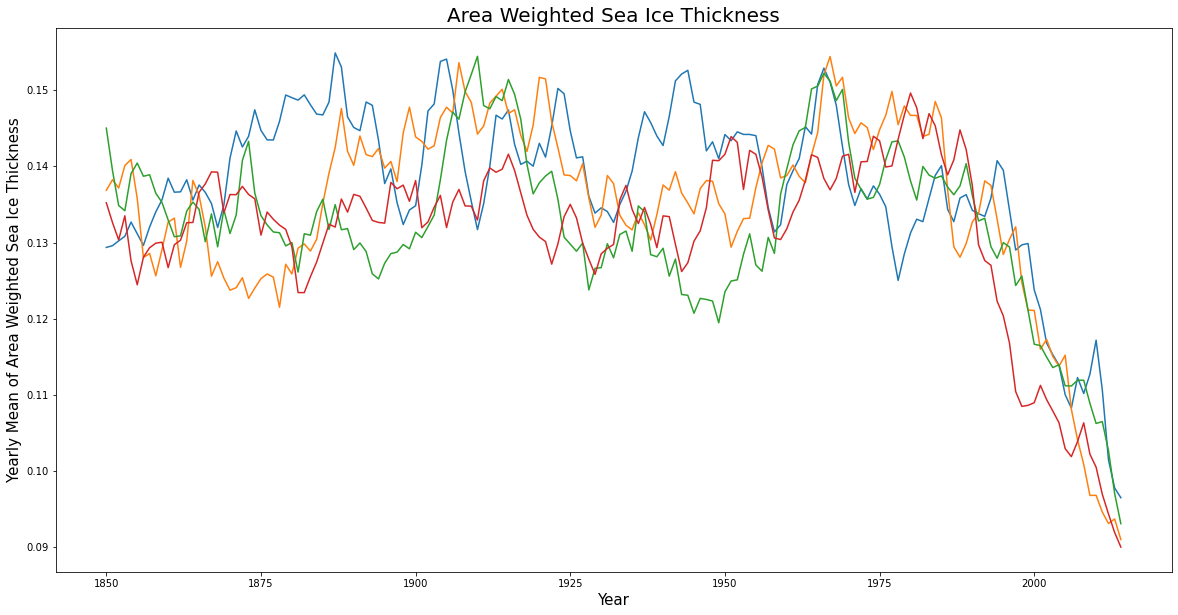

In [29]:
plt.figure(figsize=(20,10))
plt.plot(yearly_means)
plt.xlabel('Year' ,fontsize=15)
plt.ylabel('Yearly Mean of Area Weighted Sea Ice Thickness', fontsize=15)
plt.title('Area Weighted Sea Ice Thickness', fontsize=20)

Text(0.5, 1.0, 'Ensemble Mean for Area Weighted Sea Ice Thickness')

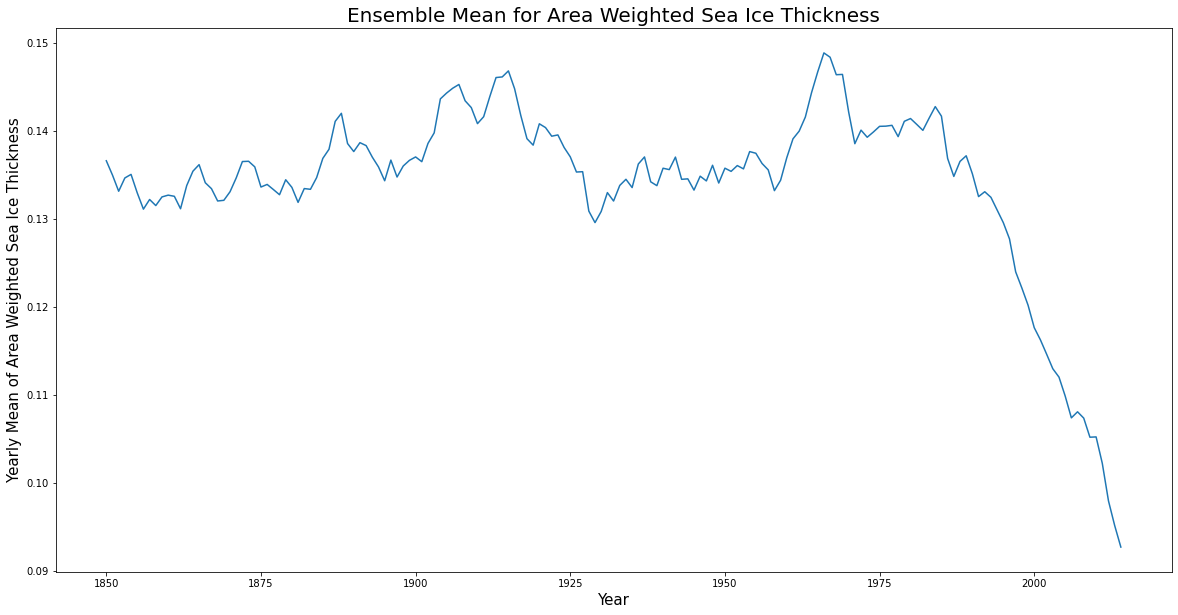

In [30]:
ensemble_mean = yearly_means.mean(axis=1)

plt.figure(figsize=(20,10))
plt.plot(ensemble_mean)
plt.xlabel('Year' ,fontsize=15)
plt.ylabel('Yearly Mean of Area Weighted Sea Ice Thickness', fontsize=15)
plt.title('Ensemble Mean for Area Weighted Sea Ice Thickness', fontsize=20)

Text(0.5, 1.0, 'Area Weighted Sea Ice Thickness')

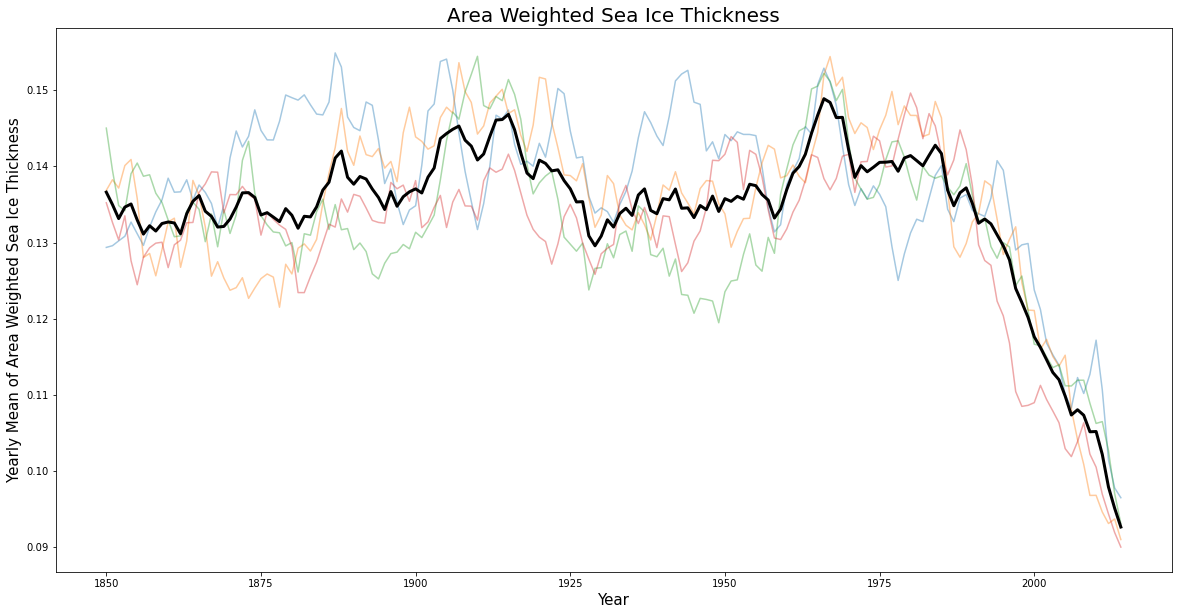

In [31]:
plt.figure(figsize=(20,10))
plt.plot(yearly_means, alpha = 0.4)
plt.plot(ensemble_mean, linewidth = 3, color = 'black')
plt.xlabel('Year' ,fontsize=15)
plt.ylabel('Yearly Mean of Area Weighted Sea Ice Thickness', fontsize=15)
plt.title('Area Weighted Sea Ice Thickness', fontsize=20)

Text(0.5, 1.0, 'Ensemble Mean for Area Weighted Sea Ice Thickness')

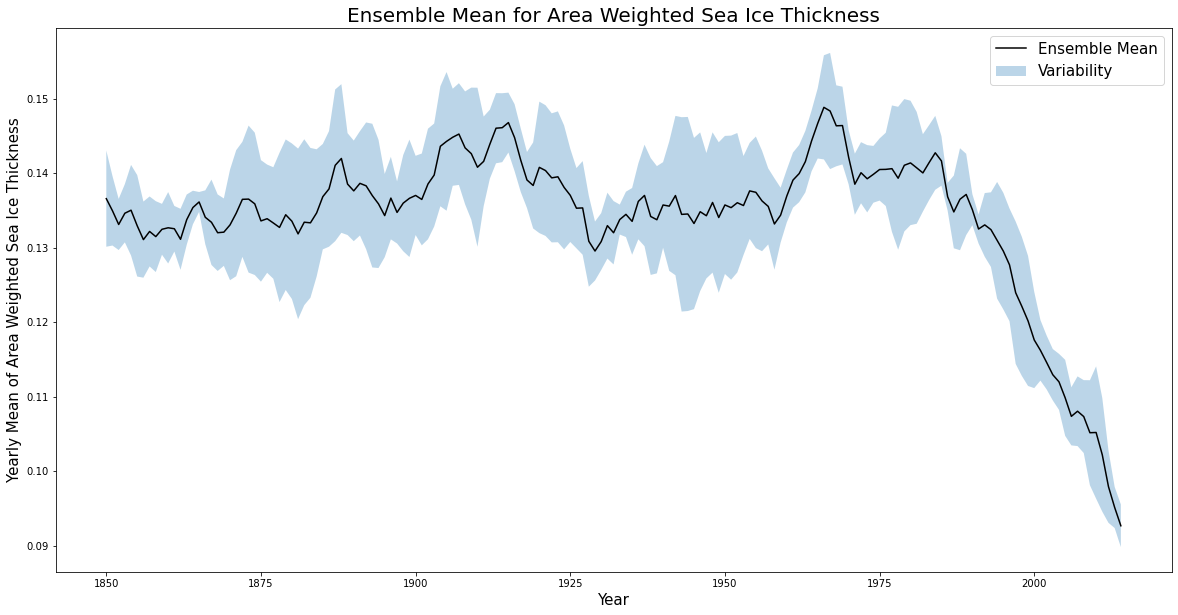

In [32]:
ensemble_std = yearly_means.std(axis=1)
top_bound_std = ensemble_mean + ensemble_std
bottom_bound_std = ensemble_mean - ensemble_std


plt.figure(figsize=(20,10))
plt.plot(ensemble_mean, color="black")
plt.fill_between(ensemble_std.index, bottom_bound_std, top_bound_std, alpha=0.3)
plt.xlabel('Year' ,fontsize=15)
plt.ylabel('Yearly Mean of Area Weighted Sea Ice Thickness', fontsize=15)
plt.legend(["Ensemble Mean", "Variability"], fontsize = 15)
plt.title('Ensemble Mean for Area Weighted Sea Ice Thickness', fontsize=20)